# Run OF on MIDAS data with external LEMO triggers (coinciding with LED)

Load MIDAS data with LED triggers. Make PSD and pulse templates, then run OF

Changelog

Oct 22 2024: First version

In [1]:
import sys
import glob
sys.path.append('..')
from arqpy import *

In [2]:
# data + channels to use
datadir = '/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/'
fns = sorted(glob.glob(datadir+'RUN08424_DUMP000*.mid.gz'))
psd_fns = sorted(glob.glob(datadir+'RUN08410_DUMP000*.mid.gz'))
chs = ['PBS2','PFS2'] # channels to use (which also serve as dictionary keys)
names = ['NFC2 A','NFC2 B']

# general
fsamp = 625000 # Hz
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4
det   = 1 # MIDAS Det01

# trigger options
trigger_mode = 3 # 0 - threshold, 1 - filter+threshold, 2 - random, 3 - external/LEMO
randomrate = 0 # random triggers to add per trace
offset = -0.00602 # fixed offset s.t. pulse = LEMO trigger - offset, sec
trigger_offsets = {} # number of bins to subtract from each trigger
for ch in chs:
    trigger_offsets[ch] = offset*fsamp

# other options
maxchi2freq = 1e4 # Hz
pretrig     = 1000 # bins
posttrig    = 4000 # bins

tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409181855
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409181855
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDat

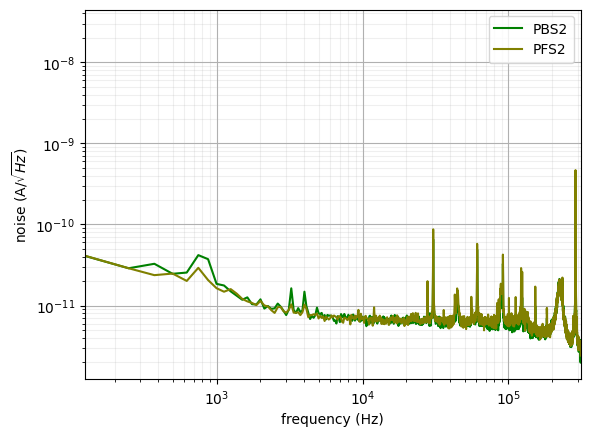

In [3]:
# make PSDs
# load traces - may take a while
traces = loadEvents(files=psd_fns[:1],detectors=[det],chs=chs,ADC2A=ADC2A)
# compute PSDs, then plot
psds = makePSDs(traces[det],chs=chs,nbins=tracelen,ntraces=100,fsamp=fsamp)
plotPSDs(psds,fsamp=fsamp,tracelen=tracelen)

In [4]:
# instantiate Reduced Quantity object, without templates
rq = RQ(data=fns, chs=chs, ch_names=names, detector=det,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=None, # !
        maxchi2freq=maxchi2freq)

Using maxchi2freq for lpfs, also


The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDat

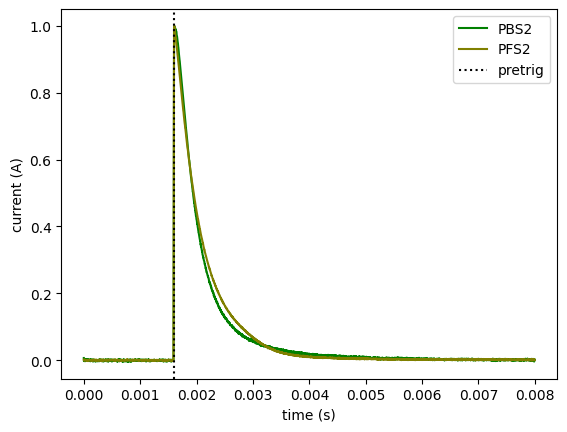

In [5]:
# use triggers to average a bunch of pulses together + use as templates
templates = {}
for ch in chs:
    template = rq.averageTrigPulse(fns[:1],ch,100,offset)
    template -= np.mean(template[:100]) # "pedestal" subtraction
    template = lpf(template,2e5,10) # not actually necessary
    template /= np.max(template)
    templates[ch] = template
    
    t = np.arange(len(template))/fsamp
    plt.plot(t,template,color=MIDAScolors[MIDASchs.index(ch)],label=ch)
plt.axvline(pretrig/fsamp,color='k',ls=':',label='pretrig')
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()


In [6]:
events = loadEvents(files=fns[:1],detectors=[1],chs=[ch],ADC2A=ADC2A,loadtrig=True)
traces = events[1]

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDat

In [7]:
# make OF (for RQs AND triggering)
rq.setTemplates(templates,ch)
rq.makeOF()

In [8]:
# run trigger
rq.runTrigger(mode=trigger_mode, chs=chs, randomrate=randomrate, trigger_offsets=trigger_offsets)

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDat

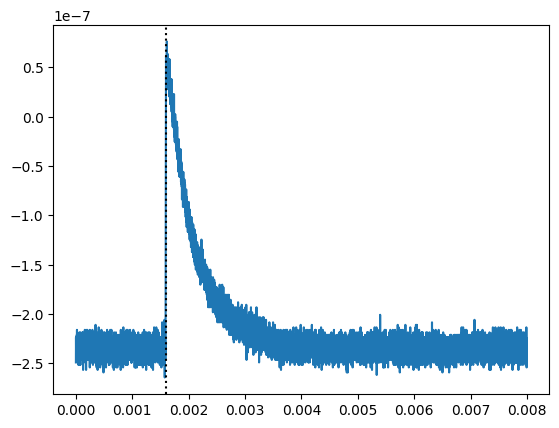

In [9]:
# did the trigger work? pulse should line up 
trace = rq.traces['PFS2'][10]
t = np.arange(len(trace))/fsamp
plt.plot(t,trace)

plt.axvline(pretrig/fsamp,color='k',ls=':')

In [10]:
# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs = rq.results

Processing PBS2. 15922 events
Processing PFS2. 15922 events


The optimal filter has been run! Now let's look at some RQs...

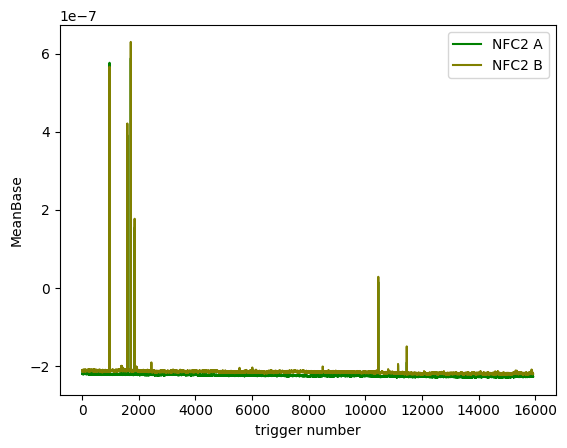

In [11]:
# look at baselines
for ch in chs:
    rq.plot1d(f'MeanBase_{ch}')
    # alternatively: plt.plot(RQs[f'MeanBase_{ch}'])

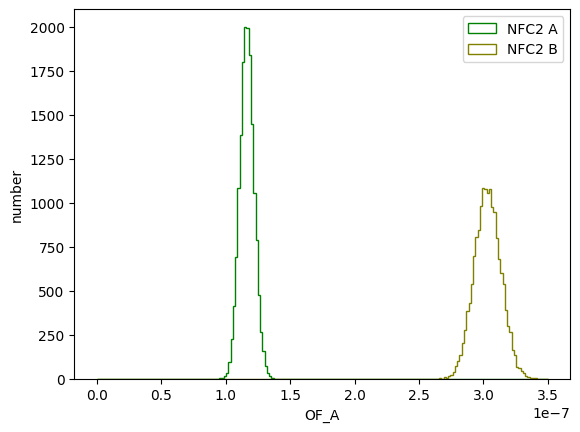

In [12]:
# "spectrum" plot
bins = np.linspace(0,3.5e-7,200)
for ch in chs:
    rq.hist1d(f'OF_A_{ch}',bins=bins)

Text(0.5, 1.0, '$\\chi^2$ vs. amplitude')

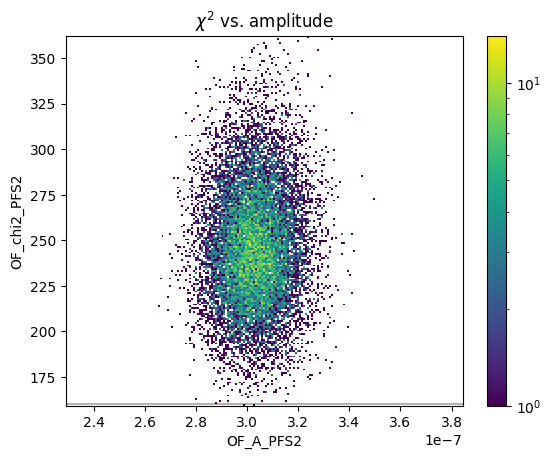

In [16]:
# chi2 vs amplitude plot
ch = chs[1]
rq.hist2d(f'OF_A_{ch}',f'OF_chi2_{ch}')
plt.axhline(2*np.sum(psdfreq<maxchi2freq),color='k',alpha=0.3)
plt.title(r'$\chi^2$ vs. amplitude')

Text(0.5, 1.0, 'Partition plot')

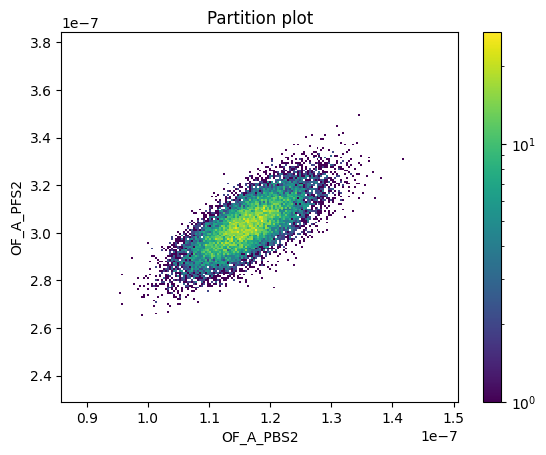

In [17]:
# "partition" plot
ch0,ch1 = chs
rq.hist2d(f'OF_A_{ch0}',f'OF_A_{ch1}')
plt.title('Partition plot')

Now let's attempt some cuts...

In [15]:
# cut on Baseline and chi2
# TODO